# Google Analytics Customer Revenue Prediction

In [1]:
# Import libraries to use

# Common imports
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
#from preprocess import read_data, json_read

from datetime import datetime # To access datetime

import warnings                # To ignore the warning
warnings.filterwarnings("ignore")

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Auxiliary Functions

In [2]:
import pandas as pd
import numpy as np
import json
import os # it's a operational system library, to set some informations

def read_data(file_path, file_name, data_format):
    """
    Parameters:
    -----------
    file_path: str 
               where the datafile is
    file_name: str
               file name of the datafile
    data_format: dict
                 format of data to import
                 
    Return
    ------
    df: dataframe
        the df after preprocessing
    """
    # Load the data
    df = pd.read_csv(file_path + file_name, dtype = data_format)
    
    # Printing the shape of dataframes that was imported     
    print("Loaded file at {}, and dataframe with shape {}".format(file_path + file_name, df.shape))
    
    return df


def json_read(df, field_name, extract_field, new_field_name):
    """
    Read semi-structured JSON data
    
    Parameters:
    ----------
    df: dataframe
        the dataframe needed to process
    field_name: str
                column to read json data
    extract_field: str 
                   info to extract from json data format
    new_field_name: str
                    add a column for data extract from json data format
                    
    Return
    ------
    df: dataframe
        the df after extracting data from json data format and adding to a new column, called new_field_name
    """
    df[new_field_name] = pd.DataFrame(df[field_name].apply(json.loads).tolist())[[extract_field]]
    return df

# 1. Load Data

Load training set:

In [3]:
chunksize = 600000
for chunk in pd.read_csv('../input/train_v2.csv', chunksize=chunksize):
    df_train = chunk
    break
    
df_train.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552


In [4]:
# Check data type in each column
df_train.dtypes

channelGrouping         object
customDimensions        object
date                     int64
device                  object
fullVisitorId           object
geoNetwork              object
hits                    object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
dtype: object

In [5]:
df_train.describe()

,date,visitId,visitNumber,visitStartTime
count,6.000000e+05,6.000000e+05,600000.000000,6.000000e+05
mean,2.016965e+07,1.496995e+09,2.326868,1.496995e+09
std,6.616833e+03,1.615465e+07,9.411814,1.615465e+07
min,2.016080e+07,1.470207e+09,1.000000,1.470208e+09
25%,2.016120e+07,1.480649e+09,1.000000,1.480649e+09
50%,2.017061e+07,1.497378e+09,1.000000,1.497378e+09
75%,2.017112e+07,1.511609e+09,1.000000,1.511609e+09
max,2.018043e+07,1.525072e+09,457.000000,1.525072e+09


In [6]:
# Check memory usage in MB
df_train.memory_usage(deep=True)* 1e-6

Index                      0.000080
channelGrouping           40.118931
customDimensions          52.913544
date                       4.800000
device                   475.229741
fullVisitorId             34.472267
geoNetwork               276.165326
hits                    7804.214594
socialEngagementType      46.200000
totals                    88.946522
trafficSource            144.106941
visitId                    4.800000
visitNumber                4.800000
visitStartTime             4.800000
dtype: float64

In [7]:
# Estimate total memory usage
usage = df_train.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 8.981567945999998 Gb


## Data Fields

- **fullVisitorId**- A unique identifier for each user of the Google Merchandise Store.
- **channelGrouping** - The channel via which the user came to the Store.
- **date** - The date on which the user visited the Store.
- **device** - The specifications for the device used to access the Store.
- **geoNetwork** - This section contains information about the geography of the user.
- **sessionId** - A unique identifier for this visit to the store.
- **socialEngagementType** - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- **totals** - This section contains aggregate values across the session.
- **trafficSource** - This section contains information about the Traffic Source from which the session originated.
- **visitId** - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- **visitNumber** - The session number for this user. If this is the first session, then this is set to 1.
- **visitStartTime** - The timestamp (expressed as POSIX time).
- **hits** - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits. (new in version 2 data set)
- **customDimensions** - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set. (new in version 2 data set)


In [8]:
chunksize = 100
for chunk in pd.read_csv('../input/test_v2.csv', chunksize=chunksize):
    df_test = chunk
    break

df_test.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7460955084541987166,"{""continent"": ""Asia"", ""subContinent"": ""Souther...","[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""3"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526099341,2,1526099341
1,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",460252456180441002,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""3"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526064483,166,1526064483
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3461808543879602873,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '12',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""4"", ""pageviews"": ""3"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526067157,2,1526067157
3,Direct,"[{'index': '4', 'value': 'North America'}]",20180511,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",975129477712150630,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '23',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526107551,4,1526107551
4,Organic Search,"[{'index': '4', 'value': 'North America'}]",20180511,"{""browser"": ""Internet Explorer"", ""browserVersi...",8381672768065729990,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""referralPath"": ""(not set)"", ""campaign"": ""(no...",1526060254,1,1526060254


In [9]:
del df_test


## What am I predicting?

The following is the sample submission.

In [10]:
df_submit = pd.read_csv('../input/sample_submission_v2.csv')
df_submit.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.0
1,0000039738481224681,0.0
2,0000073585230191399,0.0
3,0000087588448856385,0.0
4,0000149787903119437,0.0


In [11]:
del df_submit

For each `fullVisitorId` in the test set, we must predict the **natural log** of their total revenue in `PredictedLogRevenue`. The submission file should contain a header and have the following format:

```
fullVisitorId,PredictedLogRevenue
0000000259678714014,0
0000049363351866189,0
0000053049821714864,0
etc.
```

We are predicting the natural log of the **sum of all transactions per user**. For every user in the test set, the target is:

$$ y_{user}=\sum_{i=1}^{n}transaction_{user_i}$$

$$ target_{user}=\ln(y_{user}+1)$$

where $n$ is the number of times a specific customer vistied the GStore. 

**Why do we choose above metric to gauage the performance?**

Since each transaction is a large value, if we use those values directly, then it will not be sensitive to the minor changes! Thus, we  apply natural log to $y_{user}$. The reason why we consider $y_{user}+1$ is because some users may not purchase anything and $y_{user}=0$. Then $\ln (y_{user})$ will not be well-defined! In contrast, $\ln (y_{user}+1) = 0$ when $y_{user} = 0$. 

Note that Kaggle has updated dataset, `train_v2.csv` and `test_v2.csv`, and the training dataset does NOT contain data for December 1st 2018 to January 31st 2019. You must identify the unique fullVisitorIds in the provided test_v2.csv and make predictions for them for those unseen months.

In [12]:
df_train.loc[0,'geoNetwork']

'{"continent": "Europe", "subContinent": "Western Europe", "country": "Germany", "region": "not available in demo dataset", "metro": "not available in demo dataset", "city": "not available in demo dataset", "cityId": "not available in demo dataset", "networkDomain": "(not set)", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [13]:
df_train.loc[10,'device']

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Chrome OS", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

Note that `deviceCategory` and `isMobile` are related actually. If `deviceCategory` is mobile or tablet, then `isMobile` is true. If `deviceCategory` is desktop, then `isMobile` is false. We will examine these two features later to see whether it's necessary to consider `deviceCategory` or not.

In [14]:
df_train.loc[101,'device']

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Macintosh", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

In [15]:
df_train.loc[80,'totals']

'{"visits": "1", "hits": "3", "pageviews": "3", "timeOnSite": "32", "newVisits": "1", "sessionQualityDim": "1"}'

In [16]:
df_train.loc[102,'trafficSource']

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "(not provided)", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}}'

In **device, geoNetwork, totals, trafficSource** fields, they are semi-structured JSON data.

- **device**: browser, browserVersion, browserSize, operatingSystem, operatingSystemVersion, isMobile, mobileDeviceBranding, mobileDeviceModel, mobileInputSelector, mobileDeviceInfo, mobileDeviceMarketingName, flashVersion, language, screenColors, screenResolution, deviceCategory
- **totals**: visits, hits, pageviews, newVisits, bounces
- **geoNetwork**: continent, subContinent, country, region, metro, city, cityId, networkDomain, latitude, longitude, networkLocation
- **trafficSource**: campaign, source, medium, keyword, adwordsClickInfo, referralPath


In [17]:
# Extract revenue from transactionRevenue from totals field
field_name = 'totals' 
extract_field = 'transactionRevenue'
new_field_name = 'revenue'

json_read(df_train, field_name, extract_field, new_field_name).head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime,revenue
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613,NaN
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851,NaN
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552,NaN


In [18]:
# Estimate total memory usage
usage = df_train.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 9.000980529 Gb


In [19]:
# Check missing values in revenue field
df_train['revenue'].isnull().sum()

593602

There are 593602 missing values out of 600000. This is highly **imbalanced dataset**. We have to keep this in mind when we build model to do further analysis. We denote these missing values by 0 since they may be events that customers visit gstore without purchasing any products.

In [20]:
# Fill in missing data with zeros
df_train['revenue'] = df_train['revenue'].fillna(0)
df_train.head(7)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime,revenue
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450,0
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307,0
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613,0
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851,0
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552,0
5,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0166277907528479249,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '16',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/offer/2145"", ""campaign"": ""(...",1508196701,1,1508196701,0
6,Referral,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8349655975937271469,"{""continent"": ""Europe"", ""subContinent"": ""North...","[{'hitNumber': '1', 'time': '0', 'hour': '4', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/nest-vision/dr...",1508152478,1,1508152478,0


In [21]:
df_train['revenue'] = df_train['revenue'].astype('int64')
df_train.dtypes

channelGrouping         object
customDimensions        object
date                     int64
device                  object
fullVisitorId           object
geoNetwork              object
hits                    object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
revenue                  int64
dtype: object

In order to determine what factors affect whether customers purchase things or not when they visit gstore, we set 0 when revenue is 0 (not purchasing) and 1 when revenue is not 0 (purchasing) as shown in column `Buy`.

In [22]:
df_train['Buy'] = df_train['revenue'].apply(lambda x: 1 if x != 0 else 0)
df_train.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime,revenue,Buy
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450,0,0
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307,0,0
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613,0,0
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9075655783635761930,"{""continent"": ""Asia"", ""subContinent"": ""Western...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508169851,1,1508169851,0,0
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6960673291025684308,"{""continent"": ""Americas"", ""subContinent"": ""Cen...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508190552,1,1508190552,0,0


In [23]:
# Estimate total memory usage
usage = df_train.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 8.991167946 Gb


# 2. Data Explore, Clean Data and Feature Engineering

## 2.1 channelGrouping feature

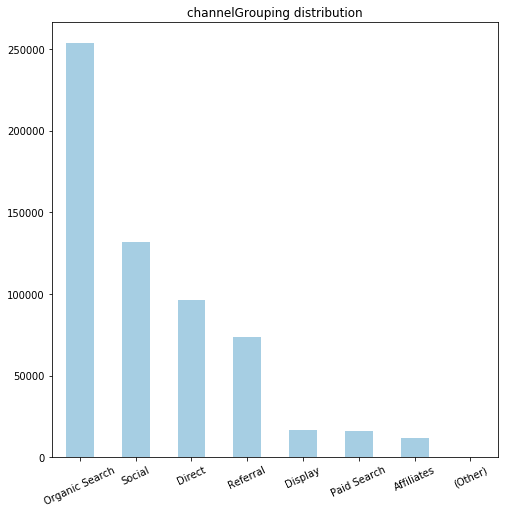

In [24]:
df_train.channelGrouping.value_counts().plot(kind="bar",title="channelGrouping distribution",figsize=(8,8),rot=25,colormap='Paired')

From above figure, we can see that most of customers used `Organic Search` channel to come to gstore, and `Social` channel is the second one. But does it mean there are more customers purchasing goods in gstore from `Organic Search` channel? Let's find out below.

### channelGrouping vs. revenue

In [25]:
df_channel = df_train[['channelGrouping','revenue', 'Buy']]
(df_channel.set_index('channelGrouping').groupby(level=0)['revenue'].agg({'mean': np.average, 'median':np.median, 'std':np.std, 
                                                                          'max': np.max, 'min': np.min}) )

,mean,median,std,max,min
channelGrouping,,,,,
(Other),0.000000e+00,0,0.000000e+00,0,0
Affiliates,3.904663e+03,0,4.099158e+05,43980000,0
Direct,2.153331e+06,0,4.978477e+07,7427430000,0
Display,4.033261e+05,0,1.355542e+07,1196740000,0
Organic Search,7.053913e+05,0,1.770549e+07,2113880000,0
Paid Search,1.370457e+06,0,2.005709e+07,1036500000,0
Referral,4.730208e+06,0,5.366916e+07,6459950000,0
Social,2.102088e+04,0,1.261872e+06,227980000,0


According to mean and median of revenue for each channelGrouping, it is clear that in each channelGrouping, there are many customers visiting gstore without purchasing! **The distribution of data in each channel is highly right-skewed**.

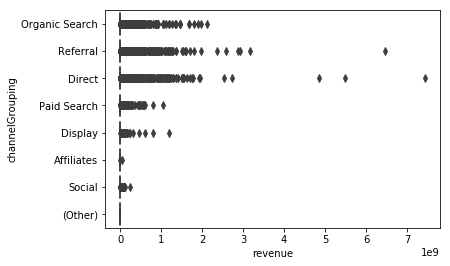

In [26]:
# Visualize the data by drawing boxplot grouped by a categorical variable:
sns.boxplot(x='revenue', y='channelGrouping', data=df_channel)

### Are those customers used specific channel most possible to buy goods in gstore?

In [27]:
Channel_Buy = (df_channel.groupby(['channelGrouping', 'Buy'])['revenue'].agg({'Count':'count'}))
Channel_Buy['Relative Frequency'] = Channel_Buy.groupby(level=0).apply(lambda x: 100*x/float(x.sum()))
Channel_Buy

Count  Relative Frequency
channelGrouping Buy                            
(Other)         0        32          100.000000
Affiliates      0     11515           99.982634
                1         2            0.017366
Direct          0     95280           98.779767
                1      1177            1.220233
Display         0     16879           99.645788
                1        60            0.354212
Organic Search  0    251685           99.251527
                1      1898            0.748473
Paid Search     0     15748           98.388104
                1       258            1.611896
Referral        0     70656           96.001304
                1      2943            3.998696
Social          0    131807           99.954500
                1        60            0.045500

From above results, we can conclude that **customers from Referral channel are most possible to buy goods in gstore per visit**. 

### Did customers who purchased goods in gstore from specific channel buy more?

In order to answer this question, we show boxplot for categorical variable (channelGrouping) vs. numerical variable (revenue).

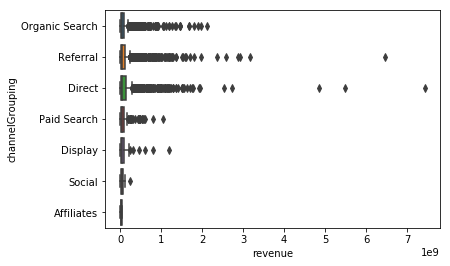

In [28]:
# boxplot for categorical variable (channelGrouping) vs. numerical variable (revenue)
df_channel_Buy = df_channel[df_channel['Buy'] == 1]
sns.boxplot(x='revenue', y='channelGrouping', data=df_channel_Buy)

From above figure, we cannot see the relation between channelGrouping and revenue due to large range of revenue in each channel. Thus, we do log transformation for revenue in the following.

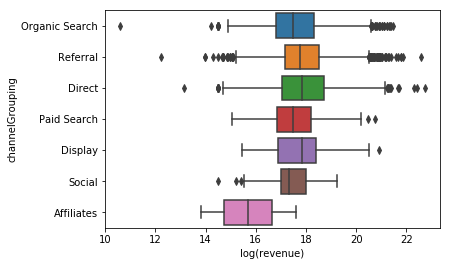

In [29]:
# Transform revenue by log function
df_channel_Buy['log(revenue)'] = df_channel_Buy['revenue'].apply(np.log)
sns.boxplot(x='log(revenue)', y='channelGrouping', data=df_channel_Buy)

From above figure, we can see that **`revenue` has very weak relationship with `channelGrouping`** since median in each channel is close to each other. Although Affiliates has much different median, it is not reliable actually since only 2 visits with purchasing. 

In [30]:
# Delete useless dataframe
del df_channel_Buy, Channel_Buy, df_channel

## 2.2 date feature

There are two variables related to time and can be used in time dependent analyzes, or Time Series. Now we study the relation between date feature and counts of customers purchasing.


**1) Hypothesis Generation**

a. There will be more customers purchasing goods during the holiday season, say Nov. and Dec.
- Explanation - Purchasing rate will be higher during the holiday season.

b. There will be more customers purchasing goods during the weekend.
- Explanation - People need to work on weekdays so they may not have time to visit GStore.

c. There will be higher transaction per visit during the holiday season, say Nov. and Dec.
- Explanation - People will buy more goods when Thanksgiving, Christmas, and New Year coming.

**2) Feature Extraction**

We will extract further info from the `date`. We have seen earlier that the data type of `date` is int64. So first of all we have to change the data type to datetime format otherwise we can not extract features from it.

In [31]:
df_train['date'] = pd.to_datetime(df_train['date'],format="%Y%m%d") 

In [32]:
df_train.head()['date']

0   2017-10-16
1   2017-10-16
2   2017-10-16
3   2017-10-16
4   2017-10-16
Name: date, dtype: datetime64[ns]

 Let's extract the year, month, day from the `date` to validate our hypothesis.

In [33]:
df_time = df_train[['date', 'revenue', 'Buy']]
df_time['year'] = pd.DatetimeIndex(df_time['date']).year
df_time['month'] = pd.DatetimeIndex(df_time['date']).month
df_time['day'] = pd.DatetimeIndex(df_time['date']).day

In [34]:
df_time.head()

,date,revenue,Buy,year,month,day
0,2017-10-16,0,0,2017,10,16
1,2017-10-16,0,0,2017,10,16
2,2017-10-16,0,0,2017,10,16
3,2017-10-16,0,0,2017,10,16
4,2017-10-16,0,0,2017,10,16


We made a hypothesis that customers will purchase more goods on weekday and weekend as well. So, let's make a weekend variable to visualize the impact of weekend on purchasing rate.

 - We will first extract the day of week from `date` and then based on the values we will assign whether the day is a weekend or not.

 - Values of 5 and 6 represents that the days are weekend.



In [35]:
df_time['DayOfWeek']=df_time['date'].dt.dayofweek
temp = df_time['date']

Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

In [36]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

temp2 = df_time['date'].apply(applyer)
df_time['weekend']=temp2

Let's look at the time series.

In [37]:
df_time.index = df_time['date'] # indexing the Datetime to get the time period on the x-axis.
df_time.head()

,date,revenue,Buy,year,month,day,DayOfWeek,weekend
date,,,,,,,,
2017-10-16,2017-10-16,0,0,2017,10,16,0,0
2017-10-16,2017-10-16,0,0,2017,10,16,0,0
2017-10-16,2017-10-16,0,0,2017,10,16,0,0
2017-10-16,2017-10-16,0,0,2017,10,16,0,0
2017-10-16,2017-10-16,0,0,2017,10,16,0,0


In [38]:
df_time_buy = df_time[df_time['Buy'] == 1]
df_time_buy.head()

,date,revenue,Buy,year,month,day,DayOfWeek,weekend
date,,,,,,,,
2017-10-16,2017-10-16,15190000,1,2017,10,16,0,0
2017-10-16,2017-10-16,8000000,1,2017,10,16,0,0
2017-10-16,2017-10-16,57300000,1,2017,10,16,0,0
2017-10-16,2017-10-16,18230000,1,2017,10,16,0,0
2017-10-16,2017-10-16,12310000,1,2017,10,16,0,0


**3) Exploratory Analysis**

Our first hypothesis was purchasing rate will be higher in holiday season.

Text(0,0.5,'Visit Count')

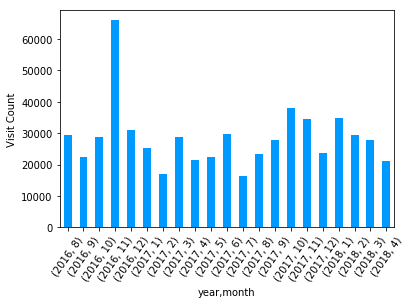

In [39]:
# using an html hex string for color
color = '#0099ff'
df_time.groupby(['year','month']).size().plot.bar(rot = 55, color=color)
plt.ylabel('Visit Count')

As we can see in above figure, **there are more customers visiting GStore in Oct. 2016**.   Are there any specific event such that there are more vists in Oct. 2016? But does it also implies higher purchasing rate in that month? Let's examine that in the following.

Text(0,0.5,'Purchasing Rate')

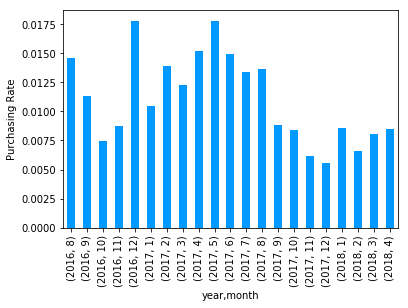

In [40]:
df_time.groupby(['year','month'])['Buy'].mean().plot.bar(color=color)
plt.ylabel('Purchasing Rate')

As we can see in above figure, **there's no clear pattern about relation between time and purchasing rate**.

Next, we examine our second hypothesis, there will be more customers purchasing goods during the weekend.

Text(0,0.5,'Purchasing Rate')

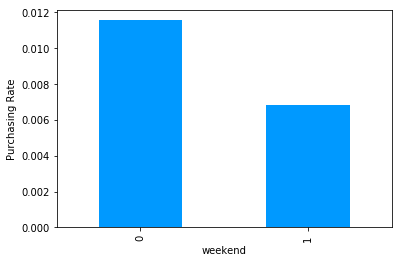

In [41]:
df_time.groupby('weekend')['Buy'].mean().plot.bar(color=color)
plt.ylabel('Purchasing Rate')

In above figure, 0 denotes the weekday and 1 denotes the weekend. It is clear that our second hypothesis is not right. From the figure, we can see that **there are higher purchasing rate in weekdays**. Probably, that is because when people work or people go to office on weekdays, they have more chances to access the electric devices to visit the Google Merchandise Store.

In the end, we examine whether there will be higher transaction per visit during the holiday season, say Nov. and Dec. in the following:

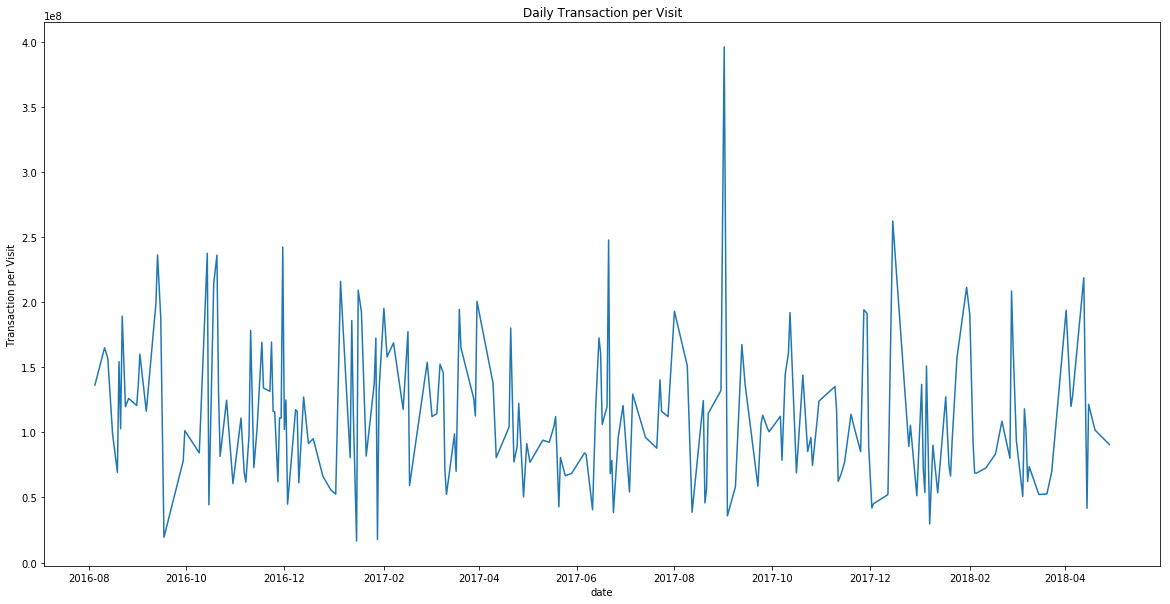

In [42]:
daily_transaction_per_visit_df = df_time_buy[['date','revenue']].groupby(by=['date'],axis=0).mean()
fig, axes = plt.subplots(figsize=(20,10))
axes.set_title("Daily Transaction per Visit")
axes.set_ylabel("Transaction per Visit")
axes.set_xlabel("date")
axes.plot(daily_transaction_per_visit_df["revenue"])

From above result, we can see that the transaction per visit do not have strong peak at Nov. and Dec. so our last hypothesis is wrong. 

In [43]:
# Clean dataframe
del daily_transaction_per_visit_df, df_time_buy, df_time

## 2.3 device feature

The field, `device`, is stored in json format. It is necessary to extract its fields and analyze them. Using `json_read` function to deserializing json values.

In [44]:
df_train.iloc[10,2]

Timestamp('2017-10-16 00:00:00')

There are many keys in device attribute with values "not available in demo dataset" so we should ignore these features. 

### What device do customers frequently use to visit the store?

In order to answer this question, we consider `deviceCategory` in the following. Note that `isMobile` and `deviceCategory` are related. In what follows, we also examine whther using `deviceCategory` can gain more insight, or one can use `isMobile` instead.

In [45]:
df_device = df_train[['device', 'revenue', 'Buy']]

In [46]:
# Extract deviceCategory from device field
field_name = 'device' 
extract_field = 'deviceCategory'
new_field_name = 'DeviceCategory'

json_read(df_device, field_name, extract_field, new_field_name).head()

,device,revenue,Buy,DeviceCategory
0,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",0,0,desktop
1,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop
2,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,mobile
3,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop
4,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop


In [47]:
# Check whether there's missing values in DeviceCategory column
pd.isna(df_device['DeviceCategory']).sum()

0

Text(0,0.5,'Visit Count')

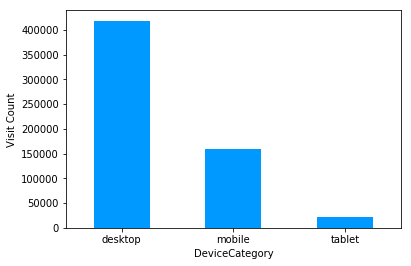

In [48]:
# using an html hex string for color
color = '#0099ff'
df_device.groupby(['DeviceCategory']).size().plot.bar(rot = 0, color=color)
plt.ylabel('Visit Count')

As we can see in the above bar plot, **most of customers visit the store via desktop device**. Also, visit counts for tablet is very small compared to mobile and desktop, and tablet and mobile can be regarded as mobile devices. Hence, we can group mobile and tablet features together, and we can classify the device is mobile device or not. This is nothing but `isMobile` in `device` attribute. Let's extract `isMobile` from `device` in the following:

In [49]:
# Extract deviceCategory from device field
field_name = 'device' 
extract_field = 'isMobile'
new_field_name = 'IsMobile'

json_read(df_device, field_name, extract_field, new_field_name).head()

,device,revenue,Buy,DeviceCategory,IsMobile
0,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",0,0,desktop,False
1,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop,False
2,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,mobile,True
3,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop,False
4,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",0,0,desktop,False


From above table, we can see that `IsMobile` is False if  `DeviceCategory` is "desktop". In contrast, `IsMobile` is True if  `DeviceCategory` is "mobile" or "tablet".

In [50]:
# Estimate total memory usage
usage = df_device.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 0.5236483160000001 Gb


In [51]:
# Check data type in IsMobile
df_device['IsMobile'].dtypes

dtype('bool')

### Is IsMobile related to purchasing rate?

Text(0,0.5,'Purchasing Rate')

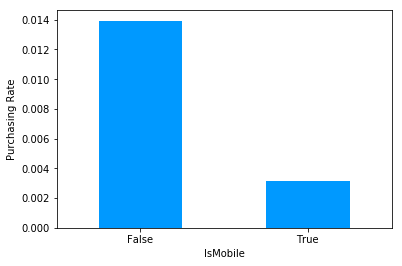

In [52]:
df_device.groupby('IsMobile')['Buy'].mean().plot.bar(color=color, rot = 0)
plt.ylabel('Purchasing Rate')

From above result, we can see that customers using desktop are more willing to purchase in store. 

### Is IsMobile related to revenue per visit?

In [53]:
df_device_Buy = df_device[df_device['Buy']==1]
df_device_Buy.head()

,device,revenue,Buy,DeviceCategory,IsMobile
433,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",15190000,1,desktop,False
550,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8000000,1,desktop,False
555,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",57300000,1,mobile,True
597,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",18230000,1,desktop,False
619,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",12310000,1,desktop,False


In [54]:
# Transform revenue by log function
df_device_Buy['log(revenue)'] = df_device_Buy['revenue'].apply(np.log)

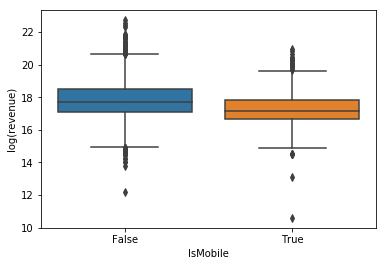

In [55]:
sns.boxplot(x='IsMobile', y='log(revenue)', data=df_device_Buy)

As we can see in the above box plot, the medians for mobile device and non-mobile device are very close to each other. This implies that revenue per visit is not correlated to `IsMobile` feature. 

In [56]:
del df_device_Buy, df_device

## 2.4 geoNetwork

The field, `geoNetwork`, is stored in json format. It is necessary to extract its fields and analyze them. Using json_read function to deserializing json values.

In [57]:
df_train.loc[21,'geoNetwork']

'{"continent": "Europe", "subContinent": "Northern Europe", "country": "United Kingdom", "region": "not available in demo dataset", "metro": "not available in demo dataset", "city": "not available in demo dataset", "cityId": "not available in demo dataset", "networkDomain": "virginm.net", "latitude": "not available in demo dataset", "longitude": "not available in demo dataset", "networkLocation": "not available in demo dataset"}'

In [58]:
df_geo = df_train[['geoNetwork', 'revenue', 'Buy']]
df_geo.head()

,geoNetwork,revenue,Buy
0,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",0,0
1,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",0,0
2,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",0,0
3,"{""continent"": ""Asia"", ""subContinent"": ""Western...",0,0
4,"{""continent"": ""Americas"", ""subContinent"": ""Cen...",0,0


In [59]:
# Estimate total memory usage
usage = df_geo.memory_usage(deep=True).sum() * 1e-6
print('Memory usage is {} Gb'.format(usage/1000))

Memory usage is 0.285765406 Gb


### Which continent has the most visitors to GStore?

In [60]:
# Extract continent from geoNetwork field
field_name = 'geoNetwork' 
extract_field = 'continent'
new_field_name = 'continent'

json_read(df_geo, field_name, extract_field, new_field_name).head()

,geoNetwork,revenue,Buy,continent
0,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",0,0,Europe
1,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",0,0,Americas
2,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",0,0,Americas
3,"{""continent"": ""Asia"", ""subContinent"": ""Western...",0,0,Asia
4,"{""continent"": ""Americas"", ""subContinent"": ""Cen...",0,0,Americas


Text(0,0.5,'visit counts')

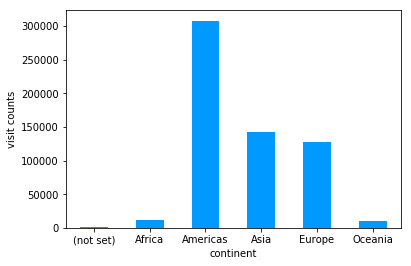

In [61]:
df_geo.groupby('continent').size().plot.bar(color=color, rot = 0)
plt.ylabel('visit counts')

From above bar plot, we can see that most of customers are from Americas. Then the second most is from Asia. And visit counts from Europe is close to Asia. Hence, we can conclude that most of customers are from these three continents, Americas, Asia, and Europe.

### Which continent has the highest purchasing rate?

Text(0,0.5,'Purchasing Rate')

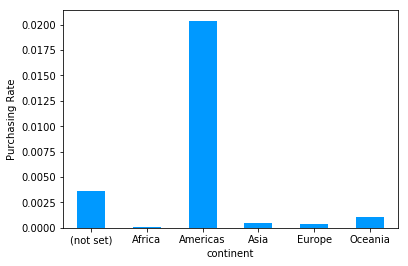

In [62]:
df_geo.groupby('continent')['Buy'].mean().plot.bar(color=color, rot = 0)
plt.ylabel('Purchasing Rate')

From above bar plot, we can see that the highest purchasing rate is in Americas. **This impliest that customers from Americas have higher possibility to buy things in GStore.** Thus, we can include this feature in our classifier.

In [63]:
# Extract country from geoNetwork field
field_name = 'geoNetwork' 
extract_field = 'country'
new_field_name = 'country'

json_read(df_geo, field_name, extract_field, new_field_name).head()

,geoNetwork,revenue,Buy,continent,country
0,"{""continent"": ""Europe"", ""subContinent"": ""Weste...",0,0,Europe,Germany
1,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",0,0,Americas,United States
2,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",0,0,Americas,United States
3,"{""continent"": ""Asia"", ""subContinent"": ""Western...",0,0,Asia,Turkey
4,"{""continent"": ""Americas"", ""subContinent"": ""Cen...",0,0,Americas,Mexico


### Which country in Americas has the highest purchasing rate?

In [64]:
df_americas = df_geo[df_geo['continent'] == 'Americas'] 
df_americas.groupby('country')['Buy'].mean().sort_values(ascending=False).head(10)

country
St. Lucia        0.066667
Belize           0.052632
Venezuela        0.028259
United States    0.024490
Puerto Rico      0.012848
Canada           0.005843
Chile            0.003053
Costa Rica       0.002841
Ecuador          0.001348
Colombia         0.001143
Name: Buy, dtype: float64

Visitors from Anguilla in Americas are the most probable to purchase goods in Gstore. But is it reasonable? Let's take a look at how many visits are from Anguilla below.

In [65]:
# How many visitors are from Anguilla?
len(df_americas[df_americas['country']=='Anguilla'])

0

It is clear that we do not have enough data from this country so we cannot conclude that visitors from Anguilla in Americas are the most probable to purchase goods in Gstore. Let's examine other countries, St. Lucia, Guadeloupe, Curaçao, and United States, with high purchasing rate in the following:

In [66]:
df_americas.groupby('country').size().sort_values(ascending=False).head(25)

country
United States         249326
Canada                 17629
Brazil                 13859
Mexico                  9376
Argentina               3632
Colombia                3501
Peru                    3340
Chile                   1310
Venezuela               1097
Ecuador                  742
Dominican Republic       617
Puerto Rico              467
Uruguay                  432
Guatemala                387
Costa Rica               352
Panama                   313
El Salvador              260
Bolivia                  242
Honduras                 150
Jamaica                  119
Trinidad & Tobago        118
Nicaragua                106
Paraguay                  82
Barbados                  47
Haiti                     45
dtype: int64

As we can see in above results, there are less than 55 visits in St. Lucia, Guadeloupe, Curaçao so we cannot conclude whether customers from these countries are more willing to buy in GStore. In contrast, **United States has the highest visits and higher purchasing rate.** This is an important feature we can consider!

### Is continent related to revenue?

In [67]:
df_geo_Buy = df_geo[df_geo['Buy']==1]
df_geo_Buy.head()

,geoNetwork,revenue,Buy,continent,country
433,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",15190000,1,Americas,United States
550,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",8000000,1,Americas,United States
555,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",57300000,1,Americas,United States
597,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",18230000,1,Americas,United States
619,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",12310000,1,Americas,United States


In [68]:
# Transform revenue by log function
df_geo_Buy['log(revenue)'] = df_geo_Buy['revenue'].apply(np.log)

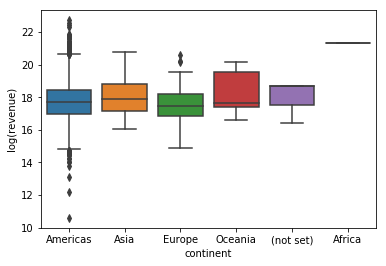

In [69]:
sns.boxplot(x='continent', y='log(revenue)', data=df_geo_Buy)

As we can see in above box plot, the median of `log(revenue)` for each continent is close, except for Africa. But the distribution of `log(revenue)` for Africa is highly right-skewed. Let's take a look at how many visits with purchasing in Africa in the following:

In [70]:
len(df_geo_Buy[df_geo_Buy['continent']== 'Africa'])

1

The samples in Africa are very less so the results cannot really show that customers from Africa contribute higher revenues compared with customers from other continents. Therefore, when we predict revenues, we will not include `continent` feature.

In [71]:
del df_americas, df_geo, df_geo_Buy

## 2.5 social Engagement Type

In this section, we study the relation between purchasing rate and `socialEngagementType`. Then we study whether `revenue` is related to `socialEngagementType`.

### Which social Engagement Type has more visits?

Text(0,0.5,'Visits')

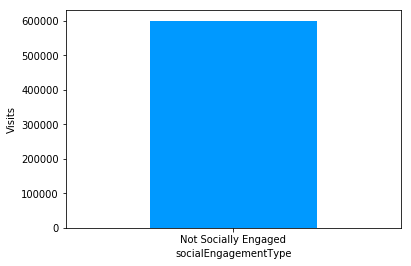

In [72]:
# using an html hex string for color
color = '#0099ff'
df_train.groupby(['socialEngagementType']).size().plot.bar(rot = 0, color=color)
plt.ylabel('Visits')

In [73]:
df_train['socialEngagementType'].count()

600000

In this feature, samples in training set are all in the same category so it is not useful to include this feature into our model.

## 2.6 Traffic Source

In [74]:
df_train.loc[101,'trafficSource']

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "(not provided)", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}, "isTrueDirect": true}'

In [75]:
df_train.loc[102,'trafficSource']

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "(not provided)", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}}'

In [76]:
df_train.loc[103,'trafficSource']

'{"campaign": "(not set)", "source": "google", "medium": "organic", "keyword": "(not provided)", "adwordsClickInfo": {"criteriaParameters": "not available in demo dataset"}}'

In above three instances, except for those not available info, the most useful feature is `medium` but it's already extracted in `channelGrouping`.

## 2.7 totals

Except for `transactionRevenue`, there are other useful features stored in json format in `totals` field like `visits`, `hits`, and `pageviews`.

In [77]:
df_train.loc[80,'totals']

'{"visits": "1", "hits": "3", "pageviews": "3", "timeOnSite": "32", "newVisits": "1", "sessionQualityDim": "1"}'

In [78]:
df_train.loc[1001,'totals']

'{"visits": "1", "hits": "1", "pageviews": "1", "bounces": "1", "newVisits": "1", "sessionQualityDim": "1"}'

In [79]:
df_train.loc[302,'totals']

'{"visits": "1", "hits": "7", "pageviews": "7", "timeOnSite": "182", "newVisits": "1", "sessionQualityDim": "2"}'

In [80]:
df_totals = df_train[['totals', 'revenue', 'Buy']]
df_totals.head()

,totals,revenue,Buy
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
1,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0
2,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0
3,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0
4,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0


In [81]:
# View momory usage including objects
df_totals.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 3 columns):
totals     600000 non-null object
revenue    600000 non-null int64
Buy        600000 non-null int64
dtypes: int64(2), object(1)
memory usage: 94.0 MB


### visits feature in totals

In [82]:
# Extract visits from totals field
field_name = 'totals' 
extract_field = 'visits'
new_field_name = 'visits'

json_read(df_totals, field_name, extract_field, new_field_name).head()

,totals,revenue,Buy,visits
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
1,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,1
2,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,1
3,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,1
4,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,1


In [83]:
df_totals.groupby('visits').size()

visits
1    600000
dtype: int64

From above result, the values in visits attribute are all 1 so this feature cannot offer any insight we need. But **it implies that in this data set, each instance is related to distinct customer visiting GStore**. 

In [84]:
# Drop unuseful feature to release memory
df_totals.drop(columns='visits', inplace=True)
df_totals.head()

,totals,revenue,Buy
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0
1,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0
2,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0
3,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0
4,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0


### hits and pageviews features in totals

In [85]:
# Extract hits from totals field
field_name = 'totals' 
extract_field = 'hits'
new_field_name = 'hits'

json_read(df_totals, field_name, extract_field, new_field_name).head()

,totals,revenue,Buy,hits
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1
1,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,2
2,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,2
3,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,2
4,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,2


In [86]:
df_totals.groupby('hits').size().head()

hits
1      302595
10       6972
100        19
101        13
102        15
dtype: int64

In [87]:
# Extract pageviews from totals field
field_name = 'totals' 
extract_field = 'pageviews'
new_field_name = 'pageviews'

json_read(df_totals, field_name, extract_field, new_field_name).head()

,totals,revenue,Buy,hits,pageviews
0,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...",0,0,1,1
1,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,2,2
2,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,2,2
3,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,2,2
4,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...",0,0,2,2


In [88]:
df_totals.groupby('pageviews').size().head()

pageviews
1      306733
10       6716
100         5
101         5
102         5
dtype: int64

In [89]:
# Check data types for values in each column
df_totals.dtypes

totals       object
revenue       int64
Buy           int64
hits         object
pageviews    object
dtype: object

In [90]:
# Convert desired columns to numeric type
df_totals[['hits', 'pageviews']] = df_totals[['hits', 'pageviews']].apply(pd.to_numeric) 
df_totals.dtypes

totals        object
revenue        int64
Buy            int64
hits           int64
pageviews    float64
dtype: object

### Take a look at correlations between revenue, Buy, hits, and pageviews

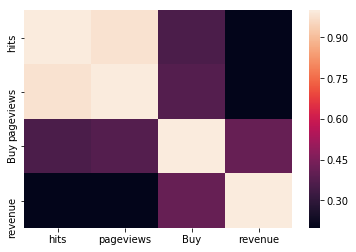

In [91]:
temp_df = df_totals[['hits','pageviews', 'Buy','revenue']]

# Calculate correlations
corr = temp_df.corr()

# Heatmap
sns.heatmap(corr)

From above heatmap, we can see that `hits` and `pageviews` have very weak relation to `revenue`. However, `hits` and `pageviews` have very highly positive correlations with `Buy`. 